In [1]:
 import pandas as pd 
data = pd.read_csv("../data/data_english/data.csv")
data.head()

,type,comment,clean_comment,word_count
0,infj,"the thing about dogs, they're better than peop...",the thing about dogs they re better than peopl...,655
1,enfp,"haha he's only 4 years older than me, so i hav...",haha he s only years older than me so i have a...,967
2,enfp,leahomme he was tested for university lemoni...,leahomme he was tested for university lemonice...,1241
3,istp,you need to come to canada! ||| you forgot thi...,you need to come to canada you forgot this.......,642
4,intp,'my ex invited me to her cheese and wine party...,my ex invited me to her cheese and wine party...,1478


# Prepare_data

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["type"])

In [2]:
from tqdm.notebook import tqdm
import pandas as pd 
def separate_data(data):
    "Crea una fila con cada post de cada autor"
    df = pd.DataFrame(columns= data.columns)
    N = data.shape[0]
    for row in tqdm(range (N)):
        df_n = pd.DataFrame(columns=data.columns)
        df_n["clean_comment"] =  data.iloc[row][1].split("|||")       #Posts de n usuario
        df_n["type"] = data.iloc[row][0]                     #Personalidad n usuario
        
        df = pd.concat([df, df_n], ignore_index=True)

    return df

In [5]:
data_separate_train = separate_data(train)

In [25]:
print(data_separate.shape)
data_separate.head()

(891399, 4)


,type,comment,clean_comment,word_count
0,infj,NaN,"the thing about dogs, they're better than peop...",NaN
1,infj,NaN,"it's well within the bounds of shamanism, but...",NaN
2,infj,NaN,so much winning! **i can't take it anymore m...,NaN
3,infj,NaN,i agree. this kid's going to go far in life.,NaN
4,infj,NaN,that is what happens when you lead from the r...,NaN


In [26]:
import random 
def balance_data(data,Y):
    "Devuelve el mismo numero de elementos para cada nivel de Y en data"
    posiciones = []
    N = data[Y].value_counts()[-1]
    for tipo in data[Y].unique():
        filtrar = list(data[data[Y]==tipo].sample(N).index)
        posiciones += filtrar
        
    random.shuffle(posiciones)
    new_data = data.iloc[posiciones]
    print(f"Dimensiones del dataset balanceado: {new_data.shape}")
    new_data = new_data.reset_index(drop=True)
        
    return new_data

In [27]:
data_balanced = balance_data(data_separate,"type")

Dimensiones del dataset balanceado: (90688, 4)


In [28]:
print(data_balanced.shape)
data_balanced.head()

(90688, 4)


,type,comment,clean_comment,word_count
0,intj,NaN,"yeeesh, selling a kidney? haha. i have a sigm...",NaN
1,estj,NaN,i have a spongei have a cake...ughhh...sponge...,NaN
2,intp,NaN,"my friends are an typemention, typemention, ty...",NaN
3,entj,NaN,i'll look into those groups. thanks for point...,NaN
4,esfj,NaN,how much gas do you use a week?,NaN


# Keras

In [ ]:
dict_code = {'i':0, 'e':1, 'n':0, 's':1, 'f':0, 't':1, 'j':0, 'p':1}
def code(tipo):
    """{'i':0, 'e':1, 'n':0, 's':1, 'f':0, 't':1, 'j':0, 'p':1} """
    return [dict_code[l] for l in tipo]


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd 
import pickle

tokenizer = pickle.load(open("../Utilities/tokenizer_english.pkl", "rb"))
vocab_shape=len(tokenizer.word_index) +1
max_len=50


def prepare_data(data):
    X = data["clean_comment"].sample(frac=1)
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X,maxlen=max_len)
    Y = data["type"]
    
    Y_4 = np.array([code(x) for x in Y])

    return X, Y_4, Y 

In [199]:
import pickle
embedding_matrix = pickle.load(open("../Utilities/embeddings/embeddings_filtered.pkl", "rb"))

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv2D, GlobalMaxPooling1D, Dense, Concatenate, Flatten
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, Dropout, Activation, MaxPool2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import  relu
from keras.callbacks import ModelCheckpoint, EarlyStopping

tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
)

def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3]
    num_filters = 36
    embed_size = 300


    inp = Input(shape=(max_len,))
    x = Embedding(vocab_shape, embed_size, weights=[embedding_matrix],  trainable=False)(inp)
    x = Reshape((max_len, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(max_len - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    
    return model



In [133]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def plot_roc(X_test, Y_test,model):
    y_pred_keras = model.predict(X_test)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
    
    
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

### Without weights

In [173]:
X, Y_4, Y  = prepare_data(data_separate)

In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_4[:,0], test_size=0.2, random_state=42, stratify=Y_4[:,0])


model = model_cnn(embedding_matrix)

from tensorflow.keras.callbacks import EarlyStopping
parada = EarlyStopping(monitor='loss', patience = 0,verbose=1)

history = model.fit(X_train,Y_train, epochs = 20, batch_size=50, validation_data=(X_test,Y_test), callbacks=[parada])

Epoch 1/20
14263/14263 [==============================] - 317s 22ms/step - loss: 0.5513 - auc_26: 0.4999 - val_loss: 0.5487 - val_auc_26: 0.5005
Epoch 2/20
14263/14263 [==============================] - 326s 23ms/step - loss: 0.5485 - auc_26: 0.5088 - val_loss: 0.5492 - val_auc_26: 0.5007
Epoch 3/20
  647/14263 [>.............................] - ETA: 4:49 - loss: 0.5503 - auc_26: 0.5271

KeyboardInterrupt: 

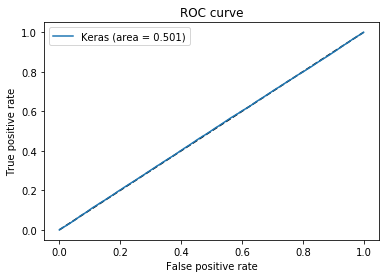

In [134]:
plot_roc(X_test,Y_test,model)

### Keras Separate weights

In [ ]:
X, Y_4, Y  = prepare_data(data_separate)

In [203]:
import pandas as pd
from collections import Counter
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

In [59]:
model = model_cnn(embedding_matrix)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_4[:,0], test_size=0.2, random_state=42, stratify=Y_4[:,0])


pesos =  get_class_weights(Y_train)

history = model.fit(X,Y_train, epochs = 5, batch_size=50, validation_split=0.2, class_weights=pesos)

Epoch 1/5
14263/14263 [==============================] - 351s 25ms/step - loss: 0.6967 - accuracy: 0.5108 - val_loss: 0.6988 - val_accuracy: 0.4730
Epoch 2/5
14263/14263 [==============================] - 326s 23ms/step - loss: 0.6951 - accuracy: 0.4970 - val_loss: 0.6990 - val_accuracy: 0.4095
Epoch 3/5
14263/14263 [==============================] - 308s 22ms/step - loss: 0.6933 - accuracy: 0.5076 - val_loss: 0.6968 - val_accuracy: 0.4900
Epoch 4/5
14263/14263 [==============================] - 313s 22ms/step - loss: 0.6905 - accuracy: 0.5200 - val_loss: 0.6958 - val_accuracy: 0.5516
Epoch 5/5
14263/14263 [==============================] - 332s 23ms/step - loss: 0.6873 - accuracy: 0.5299 - val_loss: 0.7048 - val_accuracy: 0.4754


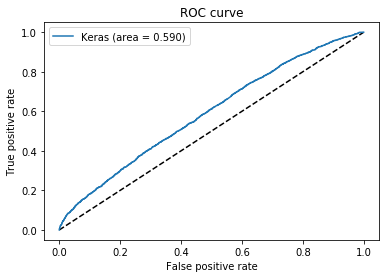

In [112]:
plot_roc(X_test,Y_test)

# 0

In [239]:
pesos =  compute_sample_weight('balanced', Y_4[:,0])
history = model.fit(X,Y_4[:,0], epochs = 10, batch_size=50, validation_split=0.2,sample_weight=pesos,shuffle=True)

Epoch 1/10
289/289 [==============================] - 148s 511ms/step - loss: 0.7252 - accuracy: 0.5359 - val_loss: 0.6803 - val_accuracy: 0.5437
Epoch 2/10
289/289 [==============================] - 159s 550ms/step - loss: 0.4934 - accuracy: 0.7837 - val_loss: 0.6957 - val_accuracy: 0.6189
Epoch 3/10
289/289 [==============================] - 145s 503ms/step - loss: 0.2531 - accuracy: 0.9462 - val_loss: 0.8076 - val_accuracy: 0.7184
Epoch 4/10
289/289 [==============================] - 140s 483ms/step - loss: 0.0967 - accuracy: 0.9906 - val_loss: 0.9044 - val_accuracy: 0.7146
Epoch 5/10
 29/289 [==>...........................] - ETA: 1:54 - loss: 0.0379 - accuracy: 0.9993

KeyboardInterrupt: 

# Keras model multilabel (Output: 4)

In [101]:
#from sklearn.utils.class_weight import  compute_sample_weight
pesos = compute_sample_weight('balanced', [x[0] for x in Y_4])
pesos

array([0.6552865 , 2.10992742, 2.10992742, ..., 0.6552865 , 0.6552865 ,
       0.6552865 ])

In [193]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, Dropout, Activation, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import  relu


filter_sizes = [1,2,3]
num_filters = 50
embed_shape = 128
dropout = 0.2

def model_4():
    
    #Entrada1
    entrada1 = Input(shape=(max_len,), name="Texto")
    #x = Embedding(vocab_shape, embed_shape, weights=[embedding_matrix], trainable=False)(entrada)
    x = Embedding(vocab_shape, embed_shape, trainable=True)(entrada1)
    x = SpatialDropout1D(dropout)(x)
    
    # BRANCH 1............................................................................
    x1 = Conv1D(num_filters , filter_sizes[0], name="CONV1D1", activation="relu")(x)
    #x1 = BatchNormalization()(x1)
    #x1 = GlobalMaxPooling1D()(x1)
    #x1 = Dropout(dropout)(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)
    
    # BRANCH 2............................................................................
    x2 = Conv1D(num_filters , filter_sizes[1], name="CONV1D2", activation="relu")(x)
    #x2 = BatchNormalization()(x2)
    #x2 = GlobalMaxPooling1D()(x2)
    #x2 = Dropout(dropout)(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)
    
    # BRANCH 3............................................................................
    x3 = Conv1D(num_filters , filter_sizes[2], name="CONV1D3", activation="relu")(x)
    #x3 = BatchNormalization()(x3)
    #x3 = GlobalMaxPooling1D()(x3)
    #x3 = Dropout(dropout)(x3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Flatten()(x3)
    
    # BRANCH 4............................................................................
    #x4 = Conv1D(num_filters , filter_sizes[3], name="CONV1D4", activation="relu")(x)
    #x4 = BatchNormalization()(x4)
    #x4 = GlobalMaxPooling1D()(x4)
    #x4 = Dropout(dropout)(x4)
    
    #Entrada2 (LIWC)............................................................................
    # entrada2 = Input(shape=(X_LIWC.shape[1],),name="LIWC")
    #x5 = Dense(64,  activation="relu")(entrada2)
    #x5 = Dropout(dropout)(x5)
    
    # entrada3 = Input(shape=(X_stat.shape[1],),name="stat")
    
    #Concat
    x = Concatenate()([x1,x2,x3])
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)
    # x = Dense(512, activation="relu")(x)
    
    
    
    #Salida
    Y0 = Dense(1, activation="sigmoid", name="Y0")(x)
    #Y1 = Dense(1, activation="sigmoid", name="Y1")(x)
    #Y2 = Dense(1, activation="sigmoid", name="Y2")(x)
    #Y3 = Dense(1, activation="sigmoid", name="Y3")(x)
    
    #model = Model(inputs=[entrada,entrada2], outputs=Y0)
    model = Model(inputs=entrada1, outputs=Y0)
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    callbacks = EarlyStopping(monitor='val_loss', patience = 0,verbose=1)
    
    return model 
   
model = model_4()
# model.summary()
#plot_model(model)


# model.fit([X,X_LIWC],[Y_4[:,0],Y_4[:,1],Y_4[:,2],Y_4[:,3]],

pesos =  compute_sample_weight('balanced', [x[1] for x in Y_4])
history = model.fit(X,Y_4[:,1],
                    batch_size=100,epochs=1,
                    validation_split=0.20,
                    callbacks = [callbacks],
                    sample_weight=pesos,
                    shuffle=True,
                    verbose=1)

145/145 [==============================] - 155s 1s/step - loss: 0.8365 - accuracy: 0.5266 - val_loss: 0.6949 - val_accuracy: 0.1542


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import  relu


filter_sizes = [1,2,3,5]
num_filters = 32
embed_shape = 300
dropout = 0.2

def model_4():
    
    #Entrada1
    entrada = Input(shape=(max_len,), name="Texto")
    x = Embedding(vocab_shape, embed_shape, weights=[embedding_matrix], trainable=False)(entrada)
    x = SpatialDropout1D(dropout)(x)
    
    # BRANCH 1............................................................................
    x1 = Conv1D(num_filters , filter_sizes[0], name="CONV1D1", activation="relu")(x)
    x1 = BatchNormalization()(x1)
    x1 = GlobalMaxPooling1D()(x1)
    x1 = Dropout(dropout)(x1)
    
    # BRANCH 2............................................................................
    x2 = Conv1D(num_filters , filter_sizes[1], name="CONV1D2", activation="relu")(x)
    x2 = BatchNormalization()(x2)
    x2 = GlobalMaxPooling1D()(x2)
    x2 = Dropout(dropout)(x2)
    
    # BRANCH 3............................................................................
    x3 = Conv1D(num_filters , filter_sizes[2], name="CONV1D3", activation="relu")(x)
    x3 = BatchNormalization()(x3)
    x3 = GlobalMaxPooling1D()(x3)
    x3 = Dropout(dropout)(x3)
    
    # BRANCH 4............................................................................
    x4 = Conv1D(num_filters , filter_sizes[3], name="CONV1D4", activation="relu")(x)
    x4 = BatchNormalization()(x4)
    x4 = GlobalMaxPooling1D()(x4)
    x4 = Dropout(dropout)(x4)
    
    #Entrada2 (LIWC)............................................................................
    entrada2 = Input(shape=(X_LIWC.shape[1],),name="LIWC")
    x5 = Dense(64,  activation="relu")(entrada2)
    x5 = Dropout(dropout)(x5)
    
    #Concat
    x = Concatenate()([x1,x2,x3,x4,x5])  
    
    
    #Salida
    Y0 = Dense(1, activation="sigmoid", name="Y0")(x)
    #Y1 = Dense(1, activation="sigmoid", name="Y1")(x)
    #Y2 = Dense(1, activation="sigmoid", name="Y2")(x)
    #Y3 = Dense(1, activation="sigmoid", name="Y3")(x)
    
    
    model = Model(inputs=[entrada,entrada2], outputs=Y0)
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    callbacks = EarlyStopping(monitor='val_loss', patience = 2,verbose=1)
    
    return model 
   
model = model_4()
model.summary()
#plot_model(model)


# model.fit([X,X_LIWC],[Y_4[:,0],Y_4[:,1],Y_4[:,2],Y_4[:,3]],

pesos =  compute_sample_weight('balanced', [x[0] for x in Y_4])
history = model.fit([X,X_LIWC],Y_4[:,0],
                    batch_size=32,epochs=1000,
                    validation_split=0.20,
                    callbacks = [callbacks],
                    sample_weight=pesos,
                    verbose=1)

Model: "functional_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Texto (InputLayer)              [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1000, 300)    19016700    Texto[0][0]                      
__________________________________________________________________________________________________
spatial_dropout1d_27 (SpatialDr (None, 1000, 300)    0           embedding_27[0][0]               
__________________________________________________________________________________________________
CONV1D1 (Conv1D)                (None, 1000, 32)     9632        spatial_dropout1d_27[0][0]       
______________________________________________________________________________________

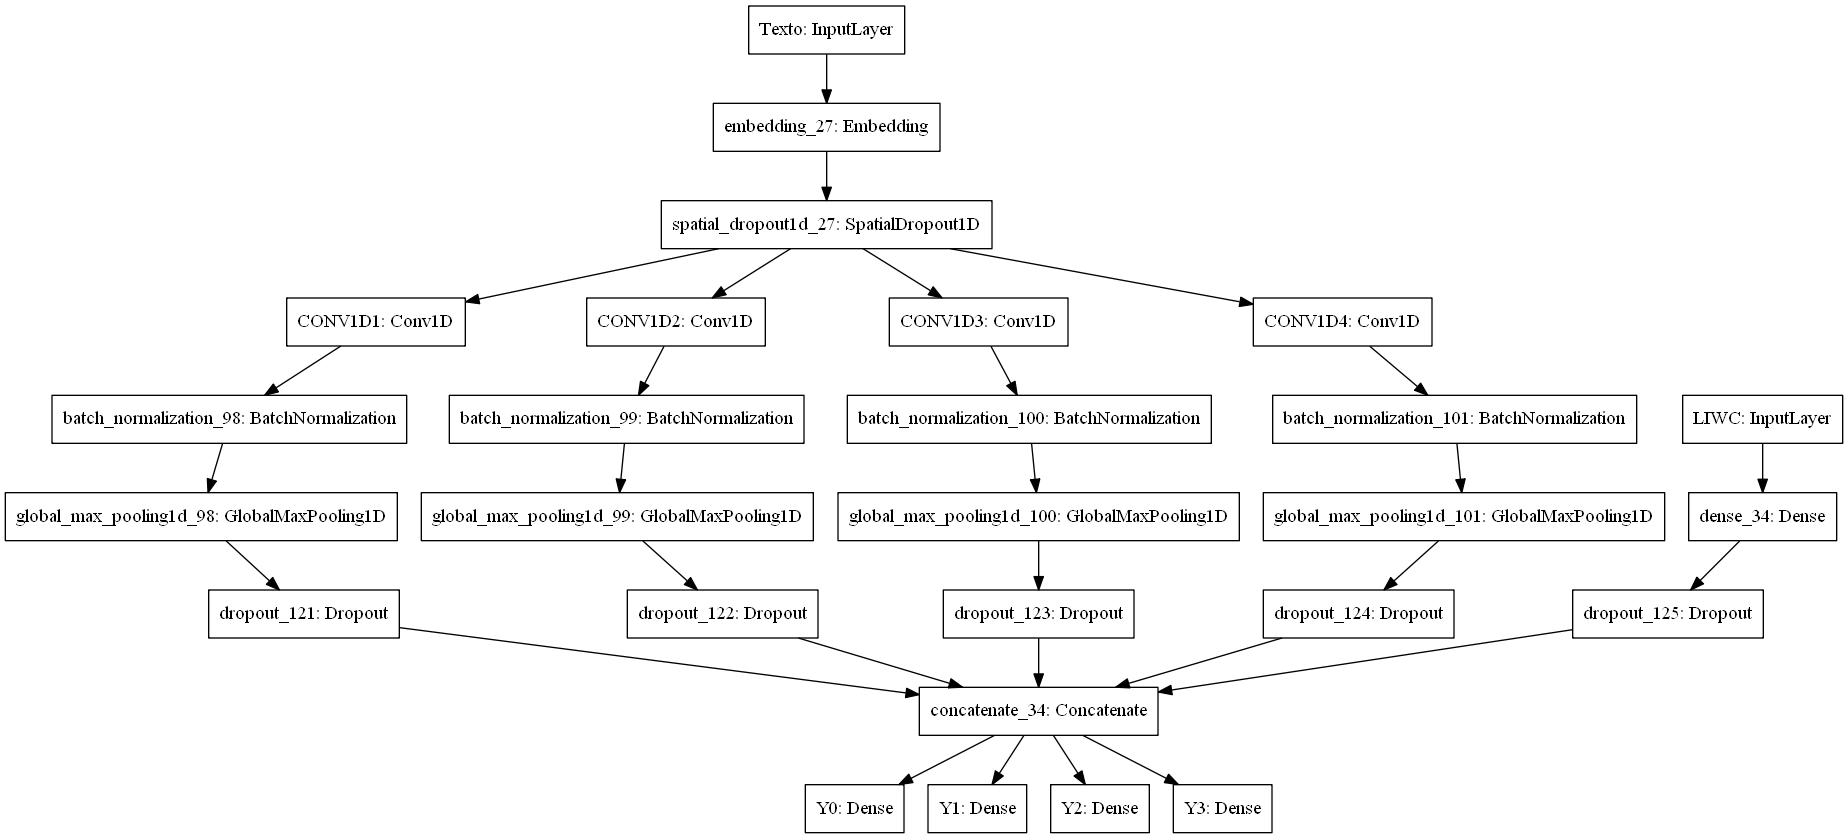

In [139]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import  relu


#
#pesos = compute_sample_weight('balanced', Y)

from sklearn.utils.class_weight import  compute_sample_weight
pesos = {}
for i in range(4):
    pesos[f"Y{i}"]= compute_sample_weight('balanced', [x[i] for x in Y_4])
pesos


filter_sizes = [1,2,3,5]
num_filters = 32
embed_shape = 300
dropout = 0.2

#Entrada
entrada = Input(shape=(max_len,), name="Texto")
x = Embedding(vocab_shape, embed_shape, weights=[embedding_matrix], trainable=False)(entrada)
x = SpatialDropout1D(dropout)(x)


# BRANCH 1
x1 = Conv1D(num_filters , filter_sizes[0], name="CONV1D1", activation="relu")(x)
x1 = BatchNormalization()(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(dropout)(x1)

# BRANCH 2
x2 = Conv1D(num_filters , filter_sizes[1], name="CONV1D2", activation="relu")(x)
x2 = BatchNormalization()(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(dropout)(x2)

# BRANCH 3
x3 = Conv1D(num_filters , filter_sizes[2], name="CONV1D3", activation="relu")(x)
x3 = BatchNormalization()(x3)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dropout(dropout)(x3)

# BRANCH 4
x4 = Conv1D(num_filters , filter_sizes[3], name="CONV1D4", activation="relu")(x)
x4 = BatchNormalization()(x4)
x4 = GlobalMaxPooling1D()(x4)
x4 = Dropout(dropout)(x4)


#Entrada2 (LIWC)
entrada2 = Input(shape=(X_LIWC.shape[1],),name="LIWC")
x5 = Dense(64,  activation="relu")(entrada2)
x5 = Dropout(0.2)(x5)


#First concat
x = Concatenate()([x1,x2,x3,x4,x5])  
# c1 = Dense(128, activation="relu")(c1)
# c1 = Dropout(dropout)(c1)




#Second concat
# x = Concatenate()([c1,xe2])
#x = Dense(64, name="Dense", activation="relu")(x)
#x = Dropout(dropout)(x)

Y0 = Dense(1, activation="sigmoid", name="Y0")(x)
Y1 = Dense(1, activation="sigmoid", name="Y1")(x)
Y2 = Dense(1, activation="sigmoid", name="Y2")(x)
Y3 = Dense(1, activation="sigmoid", name="Y3")(x)
# x = Concatenate()([Y16,x])
# Y4 = Dense(4, activation="sigmoid",name="Y4")(x)


# model = Model(inputs=[entrada,entrada2], outputs=[Y0,Y1,Y2,Y3])
model = Model(inputs=[entrada,entrada2], outputs=[Y0,Y1,Y2,Y3])
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', patience = 2,verbose=1)
# checkpoint = ModelCheckpoint('model_english.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 

model.summary()
plot_model(model)

In [141]:
pesos

{'Y0': array([0.6552865 , 2.10992742, 2.10992742, ..., 0.6552865 , 0.6552865 ,
        0.6552865 ]),
 'Y1': array([0.59018272, 0.59018272, 0.59018272, ..., 0.59018272, 0.59018272,
        0.59018272]),
 'Y2': array([1.12461001, 1.12461001, 1.12461001, ..., 0.90024975, 0.90024975,
        0.90024975]),
 'Y3': array([1.18979403, 0.86242703, 0.86242703, ..., 1.18979403, 0.86242703,
        1.18979403])}

In [142]:
history = model.fit([X,X_LIWC],[Y_4[:,0],Y_4[:,1],Y_4[:,2],Y_4[:,3]],
                    batch_size=32,epochs=1000,
                    validation_split=0.20,
                    sample_weight=pesos,
                    verbose=1)

Epoch 1/1000
451/451 [==============================] - 139s 309ms/step - loss: 3.5311 - Y0_loss: 0.8745 - Y1_loss: 0.8845 - Y2_loss: 0.8712 - Y3_loss: 0.9009 - Y0_accuracy: 0.5042 - Y1_accuracy: 0.5076 - Y2_accuracy: 0.5496 - Y3_accuracy: 0.5121 - val_loss: 2.7003 - val_Y0_loss: 0.6922 - val_Y1_loss: 0.6980 - val_Y2_loss: 0.6148 - val_Y3_loss: 0.6953 - val_Y0_accuracy: 0.2879 - val_Y1_accuracy: 0.7945 - val_Y2_accuracy: 0.6605 - val_Y3_accuracy: 0.4513
Epoch 2/1000
451/451 [==============================] - 141s 314ms/step - loss: 2.9654 - Y0_loss: 0.7447 - Y1_loss: 0.7578 - Y2_loss: 0.7079 - Y3_loss: 0.7551 - Y0_accuracy: 0.5187 - Y1_accuracy: 0.5273 - Y2_accuracy: 0.5850 - Y3_accuracy: 0.5214 - val_loss: 2.6645 - val_Y0_loss: 0.6784 - val_Y1_loss: 0.7073 - val_Y2_loss: 0.5982 - val_Y3_loss: 0.6806 - val_Y0_accuracy: 0.7440 - val_Y1_accuracy: 0.2072 - val_Y2_accuracy: 0.6810 - val_Y3_accuracy: 0.5978
Epoch 3/1000
451/451 [==============================] - 150s 334ms/step - loss: 2.79

Epoch 19/1000
451/451 [==============================] - 163s 361ms/step - loss: 2.3966 - Y0_loss: 0.6273 - Y1_loss: 0.5795 - Y2_loss: 0.5361 - Y3_loss: 0.6537 - Y0_accuracy: 0.6434 - Y1_accuracy: 0.6801 - Y2_accuracy: 0.7309 - Y3_accuracy: 0.6112 - val_loss: 2.4758 - val_Y0_loss: 0.6370 - val_Y1_loss: 0.6373 - val_Y2_loss: 0.5436 - val_Y3_loss: 0.6578 - val_Y0_accuracy: 0.6075 - val_Y1_accuracy: 0.6205 - val_Y2_accuracy: 0.7368 - val_Y3_accuracy: 0.6147
Epoch 20/1000
451/451 [==============================] - 160s 354ms/step - loss: 2.3830 - Y0_loss: 0.6292 - Y1_loss: 0.5717 - Y2_loss: 0.5345 - Y3_loss: 0.6476 - Y0_accuracy: 0.6409 - Y1_accuracy: 0.6938 - Y2_accuracy: 0.7368 - Y3_accuracy: 0.6175 - val_loss: 2.5015 - val_Y0_loss: 0.6330 - val_Y1_loss: 0.6558 - val_Y2_loss: 0.5512 - val_Y3_loss: 0.6616 - val_Y0_accuracy: 0.6438 - val_Y1_accuracy: 0.7251 - val_Y2_accuracy: 0.7118 - val_Y3_accuracy: 0.6283
Epoch 21/1000
451/451 [==============================] - 160s 356ms/step - loss: 2

KeyboardInterrupt: 

# K-FOLD

In [208]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, Dropout, Activation, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import  relu


filter_sizes = [1,2,3]
num_filters = 50
embed_shape = 128
dropout = 0.2

def model_4():
    
    #Entrada1
    entrada1 = Input(shape=(max_len,), name="Texto")
    #x = Embedding(vocab_shape, embed_shape, weights=[embedding_matrix], trainable=False)(entrada)
    x = Embedding(vocab_shape, embed_shape, trainable=True)(entrada1)
    x = SpatialDropout1D(dropout)(x)
    
    # BRANCH 1............................................................................
    x1 = Conv1D(num_filters , filter_sizes[0], name="CONV1D1", activation="relu")(x)
    #x1 = BatchNormalization()(x1)
    #x1 = GlobalMaxPooling1D()(x1)
    #x1 = Dropout(dropout)(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)
    
    # BRANCH 2............................................................................
    x2 = Conv1D(num_filters , filter_sizes[1], name="CONV1D2", activation="relu")(x)
    #x2 = BatchNormalization()(x2)
    #x2 = GlobalMaxPooling1D()(x2)
    #x2 = Dropout(dropout)(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)
    
    # BRANCH 3............................................................................
    x3 = Conv1D(num_filters , filter_sizes[2], name="CONV1D3", activation="relu")(x)
    #x3 = BatchNormalization()(x3)
    #x3 = GlobalMaxPooling1D()(x3)
    #x3 = Dropout(dropout)(x3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Flatten()(x3)
    
    # BRANCH 4............................................................................
    #x4 = Conv1D(num_filters , filter_sizes[3], name="CONV1D4", activation="relu")(x)
    #x4 = BatchNormalization()(x4)
    #x4 = GlobalMaxPooling1D()(x4)
    #x4 = Dropout(dropout)(x4)
    
    #Entrada2 (LIWC)............................................................................
    # entrada2 = Input(shape=(X_LIWC.shape[1],),name="LIWC")
    #x5 = Dense(64,  activation="relu")(entrada2)
    #x5 = Dropout(dropout)(x5)
    
    # entrada3 = Input(shape=(X_stat.shape[1],),name="stat")
    
    #Concat
    x = Concatenate()([x1,x2,x3])
    x = Dense(512, activation="relu")(x)
    x = Dropout(dropout)(x)
    # x = Dense(512, activation="relu")(x)
    
    
    
    #Salida
    Y0 = Dense(1, activation="sigmoid", name="Y0")(x)
    #Y1 = Dense(1, activation="sigmoid", name="Y1")(x)
    #Y2 = Dense(1, activation="sigmoid", name="Y2")(x)
    #Y3 = Dense(1, activation="sigmoid", name="Y3")(x)
    
    #model = Model(inputs=[entrada,entrada2], outputs=Y0)
    model = Model(inputs=entrada1, outputs=Y0)
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    callbacks = EarlyStopping(monitor='val_loss', patience = 0,verbose=1)
    
    return model 
   
model = model_4()
# model.summary()
#plot_model(model)


# model.fit([X,X_LIWC],[Y_4[:,0],Y_4[:,1],Y_4[:,2],Y_4[:,3]],



In [206]:
X.shape

(18023, 1000)

In [209]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_score = []
Y = Y_4[:,0]
for train, test in kfold.split(X, Y):
    print("Prepare kfold")
    
    model = model_4()
    pesos =  compute_sample_weight('balanced', Y[train])
    history= model.fit(X[train], Y[train], epochs=1, batch_size=50, verbose=0, sample_weight=pesos)
    
    score = model.evaluate(X[test], Y[test], verbose=0)
    print(score[0])
    cv_score.append(score[0] * 100)
cv_score

Prepare kfold
0.668164074420929
Prepare kfold
0.7067193984985352
Prepare kfold
0.5976184606552124
Prepare kfold
0.6673294901847839
Prepare kfold
0.6936944723129272


[66.8164074420929,
 70.67193984985352,
 59.76184606552124,
 66.7329490184784,
 69.36944723129272]

In [210]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_score = []
Y = Y_4[:,1]
for train, test in kfold.split(X, Y):
    print("Prepare kfold")
    
    model = model_4()
    pesos =  compute_sample_weight('balanced', Y[train])
    history= model.fit(X[train], Y[train], epochs=1, batch_size=50, verbose=0, sample_weight=pesos)
    
    score = model.evaluate(X[test], Y[test], verbose=0)
    print(score[0])
    cv_score.append(score[0] * 100)
cv_score

Prepare kfold
0.6411149501800537
Prepare kfold
0.5669697523117065
Prepare kfold
0.7971045970916748
Prepare kfold
0.6913929581642151
Prepare kfold
0.6989805102348328


[64.11149501800537,
 56.696975231170654,
 79.71045970916748,
 69.13929581642151,
 69.89805102348328]